# Automatic form filling with LaVague

<a target="_blank" href="https://colab.research.google.com/github/lavague-ai/LaVague/blob/main/docs/docs/get-started/quick-tour-notebook/quick-tour.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

This notebook shows how one can combine Hugging Face [Idefics2-8b](https://huggingface.co/HuggingFaceM4/idefics2-8b) model with LaVague to create an agent that can take a CV, perform OCR and apply to jobs automatically by filling a candidate form.

You can see it in action below:

![GIF](https://raw.githubusercontent.com/lavague-ai/LaVague/main/docs/assets/demo_lavague_form_idefics.gif)

You can run this example directly with a [CLI script available here](https://github.com/lavague-ai/LaVague/blob/main/examples/idefics_example.py).


This notebook will go through this example step by step to get into more details.

## Pre-requisites

**Note**: We use OpenAI's models, for the embedding, LLM and Vision model. You will need to set the OPENAI_API_KEY variable in your local environment with a valid API key for this example to work.

If you don't have an OpenAI API key, please [get one here](https://platform.openai.com/docs/quickstart/developer-quickstart).

You can also [get a Hugging Face token here](https://huggingface.co/docs/hub/security-tokens).

# Installation

For this example, we will use Hugging Face Inference API, OpenAI API, and LaVague.

In [1]:
!pip install text-generation lavague

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We will need to set our OpenAI Key. If you are running this as a Colab, you can provide it through Colab secrets (see the key icon on the left-hand side of the Colab notebook) named 'OPENAI_API_KEY' and then convert it to an environment variable with the same name.

In [2]:
import os

# Check if running in Google Colab
try:
    from google.colab import userdata
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
  fetch_secret = userdata.get
else:
  fetch_secret = os.getenv

import yaml
from text_generation import Client

os.environ["OPENAI_API_KEY"] = fetch_secret("OPENAI_API_KEY")

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


# OCR with Hugging Face Idefics2-8b

We will use here Hugging Face Inference API to leverage the model Idefics2-8b, an open-source Multimodal LLM, in order to extract the description of the candidate from her resume.

In [3]:
from text_generation import Client
import os

BASE_URL = "https://api-inference.huggingface.co/models/"
BASE_MODEL= "HuggingFaceM4/idefics2-8b"
SYSTEM_PROMPT = "System: The following is a conversation between Idefics2, a highly knowledgeable and intelligent visual AI assistant created by Hugging Face, referred to as Assistant, and a human user called User. In the following interactions, User and Assistant will converse in natural language, and Assistant will do its best to answer User’s questions. Assistant has the ability to perceive images and reason about them, but it cannot generate images. Assistant was built to be respectful, polite and inclusive. It knows a lot, and always tells the truth. When prompted with an image, it does not make up facts.<end_of_utterance>\nAssistant: Hello, I'm Idefics2, Huggingface's latest multimodal assistant. How can I help you?<end_of_utterance>\n"

class HuggingFaceMMLLM:
    def __init__(self, hf_api_key=None, model=BASE_MODEL, base_url = BASE_URL):
        if hf_api_key is None:
            hf_api_key = fetch_secret("HF_TOKEN")
            if hf_api_key is None:
                raise ValueError("HF_TOKEN is not set")

        api_url = base_url + model

        self.client = Client(
            base_url=api_url,
            headers={"x-use-cache": "0", "Authorization": f"Bearer {hf_api_key}"},
            )

    def upload_image(self, file_path, cloudinary_config=None):
        import cloudinary
        import cloudinary.uploader
        if cloudinary_config is None:
            cloudinary_config = {
                "cloud_name": fetch_secret("CLOUDINARY_CLOUD_NAME"),
                "api_key": fetch_secret("CLOUDINARY_API_KEY"),
                "api_secret": fetch_secret("CLOUDINARY_API_SECRET"),
                }
            if None in cloudinary_config.values():
                raise ValueError("CLOUDINARY_CLOUD_NAME, CLOUDINARY_API_KEY, or CLOUDINARY_API_SECRET is not set")

            cloudinary.config(**cloudinary_config)
        img_url = cloudinary.uploader.upload(file_path)["url"]
        return img_url

    def complete(self, query, file_path=None, url=None):
        if file_path is None and url is None:
            raise ValueError("Either file_path or url must be provided")

        generation_args = {
            "max_new_tokens": 512,
            "repetition_penalty": 1.1,
            "do_sample": False,
        }

        if file_path:
            img_url = self.upload_image(file_path)
        else:
            img_url = url

        prompt_with_image = SYSTEM_PROMPT + f"User:![]({img_url}) {query}<end_of_utterance>\nAssistant:"
        generated_text = self.client.generate(prompt=prompt_with_image, **generation_args).generated_text

        return generated_text


We can see the resume used below:

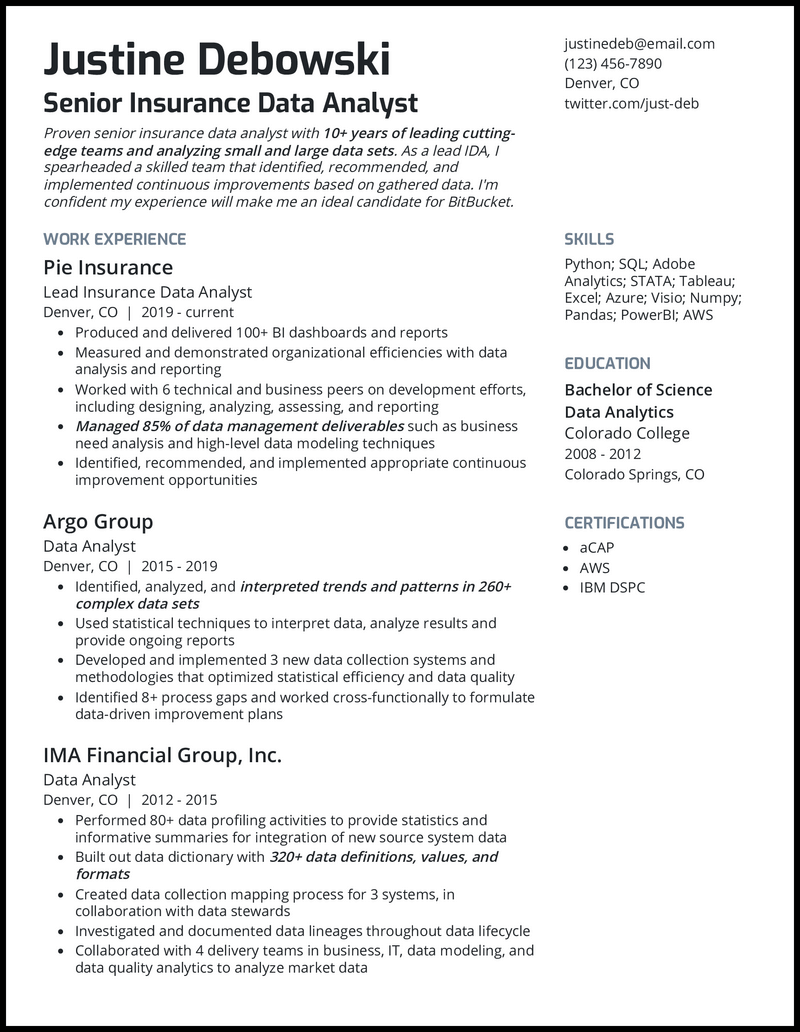

In [4]:
from IPython.display import display, Image

url = "https://d25zcttzf44i59.cloudfront.net/minimalist-resume-template.png"

display(Image(url))

We can now extract the person's details using Idefics2-8b:

In [5]:
hf_mm_llm = HuggingFaceMMLLM()

query = "Extract name, email, phone number, current company, a summary of experience, and a summary of education from this cv. Provide your output in YAML format."

user_data = hf_mm_llm.complete(query=query, url=url)

print(user_data)

 name: Justine Debowski
email: justinedeb@email.com
phone_number: (123) 456-7890
current_company: IMA Financial Group, Inc.
experience:
  - Lead Insurance Data Analyst
  - Pie Insurance
education:
  - Colorado College
  - Boulder College
  - Metropolitan State University of Denver
  - University of Colorado at Denver.


Our class defined above takes URL as inputs. This seems to be because Hugging Face API only accepts images through URL `prompt_with_image = SYSTEM_PROMPT + f"User:![]({img_url}) {query}<end_of_utterance>\nAssistant:"`.

We provide a workaround by using Cloudinary to upload an image first and then get the URL of the uploaded image to Hugging Face API.

You will need to look at https://cloudinary.com/documentation/image_upload_api_reference for more information to get your credentials.

In [6]:
# Uncomment the example below to drop your images and try with them

# !pip install cloudinary
# !wget https://i.ibb.co/HDV3m97/Business-Resume.png

# file_path = "Business-Resume.png"
# response = hf_mm_llm.complete(query=query, file_path=file_path)

# print(user_data)

# AI Web Agent building with LaVague

Here we will define and run an agent using LaVague.

LaVague has two main components:
- **A World Model**: Module specialized in reasoning, which takes as input the user’s objective ("Fill this form") and the screenshot of the web driver, and produces instructions ("Click on Apply button") to our action engine. It is powered by OpenAI GPT-4o.
- **An Action Engine**: Module specialized in turning instructions from the World Model into Selenium code. It is powered by [Llama Index](https://docs.llamaindex.ai/en/stable/) to perform RAG on the HTML.

For this demo, we will use a local embedding model ([bge-small](https://huggingface.co/BAAI/bge-small-en-v1.5)) and GPT-3.5 for our Action Engine.

In [10]:
!pip install llama-index-embeddings-huggingface

from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embedding = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

We can now run the model using the previously extracted data.

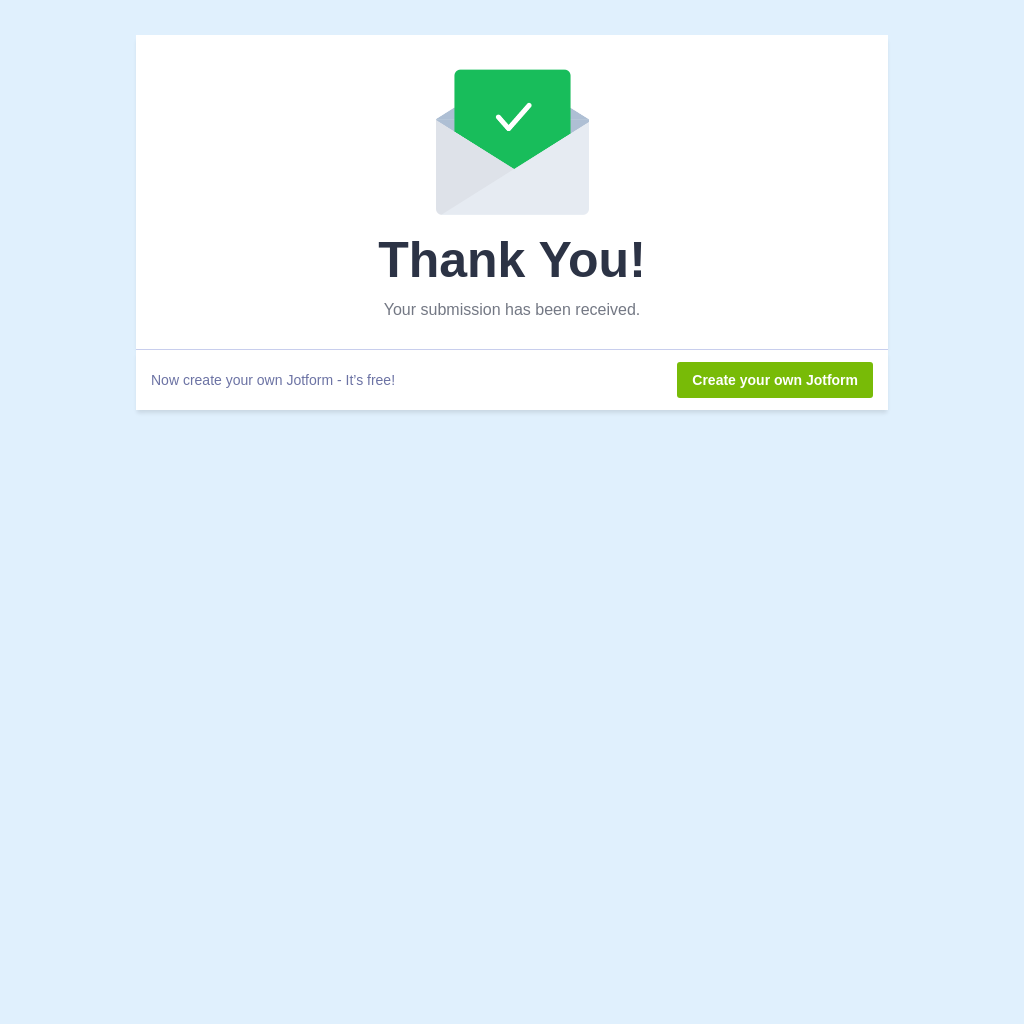

Thoughts:
- The current screenshot shows a confirmation page indicating that the form submission has been successfully received.
- The objective to fill out the form without providing a cover letter has been achieved.
- No further actions are required.

Next engine: STOP
Instruction: STOP
Objective reached. Stopping...


[]

In [11]:
from lavague.drivers.selenium import SeleniumDriver
from lavague.core import ActionEngine, WorldModel
from lavague.core.agents import WebAgent

selenium_driver = SeleniumDriver()
action_engine = ActionEngine(selenium_driver, embedding=embedding)
world_model = WorldModel()

agent = WebAgent(world_model, action_engine)

url = "https://form.jotform.com/241472287797370"
objective = "Fill out this form. Do not provide a cover letter"

agent.get(url)
agent.run(objective, user_data=user_data, display=True)